In [1]:
# Imporing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Task 1.
**Loading and Exploring the Dataset** :
The first task is to load the dataset containing historical ride data. Take a look at the structure of the data, examine the features, and gain insights into the variables that may influence the fare amount. 

In [2]:
#Loading dataset
df=pd.read_csv('uber.csv')

Exploring the data

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.shape

(200000, 9)

Task 2 
**Handling Missing Data**

In [5]:
# checking for null values
df.isna().sum().sort_values(ascending=False)

dropoff_longitude    1
dropoff_latitude     1
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
passenger_count      0
dtype: int64

In [6]:
# As there are only 2 rows with null value so droping them will not effect our analysis
df=df.dropna()

In [7]:
df.shape

(199999, 9)

In [8]:
df.isna().sum().sum()

0

In [9]:
# Exploring the column fare_amount
df['fare_amount'].describe()

count    199999.000000
mean         11.359892
std           9.901760
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

In [10]:
# The minimum value of -52.00 suggests there may be outliers or data entry errors in the dataset, as fares are generally non-negative. 

In [11]:
# Making all fare amounts positive
df['fare_amount'] = df['fare_amount'].abs()

In [12]:
df['fare_amount'].describe()

count    199999.000000
mean         11.362780
std           9.898445
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

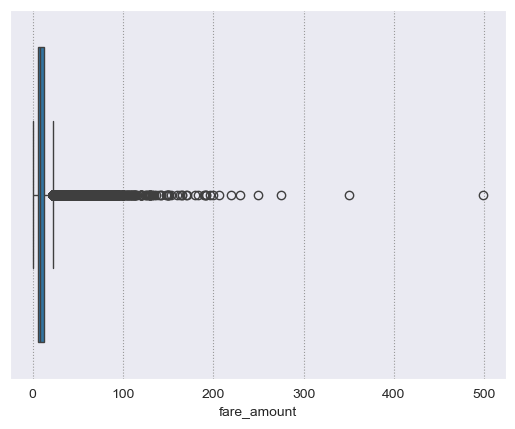

In [13]:
# checking for outliers in the dataset
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.boxplot(data=df,x='fare_amount')
plt.show()

In [14]:
# using IQR Method for Outliers
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['fare_amount'] >= lower_bound) & (df['fare_amount'] <= upper_bound)]

In [15]:
df.shape

(182839, 9)

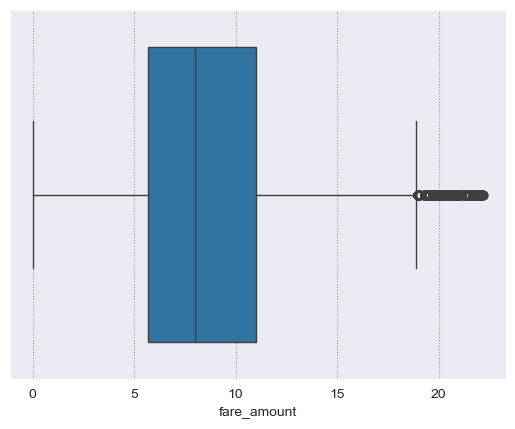

In [16]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.boxplot(data=df,x='fare_amount')
plt.show()

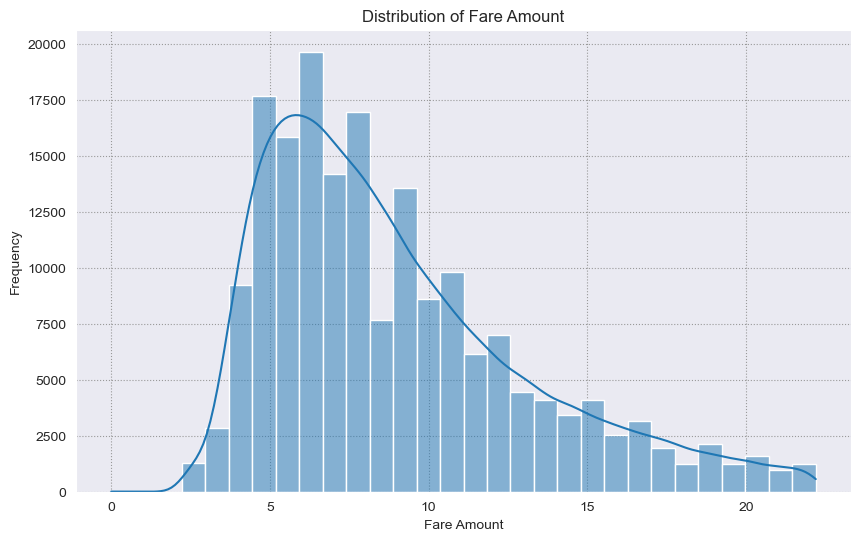

In [17]:
# Undestanding distribution of fare_amount
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=30, kde=True)
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Amount')
plt.show()

In [18]:
# histogram shows that data is skewed right

Task 3 
**Feature Engineering**

In [19]:
df = df[(df['pickup_latitude']  >= -90) & (df['pickup_latitude'] <= 90)]

In [20]:
df = df[(df['dropoff_latitude']  >= -90) & (df['dropoff_latitude'] <= 90)]

In [21]:
df.shape

(182834, 9)

In [22]:
# calculating the haversine distance between pickup and drop-off points
from geopy.distance import geodesic
import pandas as pd

# Defining the function to calculate distance
def calculate_distance(row):
    try:
        pickup = (row['pickup_latitude'], row['pickup_longitude'])
        dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
        return geodesic(pickup, dropoff).kilometers
    except Exception as e:
        print(f"Error calculating distance for row {row.name}: {e}")
        return None  # Return None for rows with errors

# Checking for missing data in critical columns
df = df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

# Appling the function and calculate distance
df['distance_km'] = df.apply(calculate_distance, axis=1)

In [23]:
# Convert pickup_datetime to datetime if not already
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Check for any invalid conversions
if df['pickup_datetime'].isnull().any():
    print("Some values in 'pickup_datetime' could not be converted to datetime format. Check for invalid entries.")

# Now extract hour of day
df['hour'] = df['pickup_datetime'].dt.hour

# Time of Day (morning, afternoon, evening, night)
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['hour'].apply(get_time_of_day)

# Day of the week (0=Monday, 6=Sunday)
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Month
df['month'] = df['pickup_datetime'].dt.month

In [24]:
# Creating a binary feature to indicate if the ride happened during rush hours (e.g., 7–9 AM and 4–7 PM). Fares may be higher during these periods.
def is_rush_hour(hour):
    return 1 if (7 <= hour <= 9) or (16 <= hour <= 19) else 0

df['rush_hour'] = df['hour'].apply(is_rush_hour)

In [25]:
# Creating a binary indicator for whether the trip occurred on a holiday
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df['pickup_datetime'].min(), end=df['pickup_datetime'].max())
df['holiday'] = df['pickup_datetime'].dt.date.isin(holidays.date).astype(int)

In [26]:
# Create a binary feature indicating whether the ride occurred on a weekend
df['weekend'] = df['pickup_datetime'].dt.dayofweek.isin([5, 6]).astype(int)

In [27]:
# 2. Distance Features
from math import radians, sin, cos, sqrt, atan2

# Haversine function to calculate distance in kilometers
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c  # in kilometers
    return distance

# Apply the haversine function to calculate distances
df['distance_km'] = df.apply(
    lambda row: haversine(
        row['pickup_latitude'], row['pickup_longitude'], 
        row['dropoff_latitude'], row['dropoff_longitude']
    ), axis=1
)

In [28]:
# Creating feature fare per kilometer to capture any anomalies or consistency in pricing across trips
df['fare_per_km'] = df['fare_amount'] / df['distance_km']

In [29]:
# Exploring new columns
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour,time_of_day,day_of_week,month,rush_hour,holiday,weekend,fare_per_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,19,evening,3,5,1,0,0,4.455474
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,20,evening,4,7,0,0,0,3.133151
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,21,evening,0,8,0,0,0,2.561365
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,8,morning,4,6,1,0,0,3.189536
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,17,evening,3,8,1,0,0,3.575060


In [30]:
# 3. Passenger-Related Features
# Passenger Count Categories
def categorize_passenger_count(count):
    if count == 1:
        return 'solo'
    elif count <= 3:
        return 'small group'
    else:
        return 'large group'

df['passenger_category'] = df['passenger_count'].apply(categorize_passenger_count)

In [31]:
# Removing infinity values from dataset
df= df.replace([np.inf, -np.inf], np.nan)

In [32]:
df['fare_per_km'] = df['fare_per_km'].fillna(df['fare_per_km'].mean())

Task 4 
**Split the Dataset**

In [33]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['fare_amount','Unnamed: 0','pickup_datetime','key'])
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour,time_of_day,day_of_week,month,rush_hour,holiday,weekend,fare_per_km,passenger_category
131495,0.000000,0.000000,0.000000,0.000000,5,0.000000,19,evening,2,9,1,0,0,15.377734,large group
183988,-73.966353,40.799533,-73.974270,40.784830,1,1.765530,11,morning,5,9,0,0,1,3.001932,solo
178251,-73.969762,40.763371,-73.958264,40.764284,1,0.973667,9,morning,0,5,1,0,0,8.729883,solo
10748,-74.005059,40.741572,-73.975334,40.757750,1,3.083171,3,night,4,1,0,0,0,2.756902,solo
78705,-73.992173,40.759276,-73.992014,40.738286,1,2.334020,9,morning,2,3,1,0,0,5.784012,solo


Task 5
**Data Scaling/Normalization**

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Selecting columns to scale (e.g., distance_km, hour, passenger_count)
# Make sure to exclude categorical columns that don’t need scaling.
numeric_features = ['month','passenger_count','distance_km','hour','day_of_week','month','rush_hour','holiday','weekend','fare_per_km']  # Example of numeric features

# Option 1: StandardScaler (standardization)
scaler_standard = StandardScaler()
X_train_scaled_standard = X_train.copy()
X_test_scaled_standard = X_test.copy()
X_train_scaled_standard[numeric_features] = scaler_standard.fit_transform(X_train[numeric_features])
X_test_scaled_standard[numeric_features] = scaler_standard.transform(X_test[numeric_features])

# Option 2: MinMaxScaler (normalization)
scaler_minmax = MinMaxScaler()
X_train_scaled_minmax = X_train.copy()
X_test_scaled_minmax = X_test.copy()
X_train_scaled_minmax[numeric_features] = scaler_minmax.fit_transform(X_train[numeric_features])
X_test_scaled_minmax[numeric_features] = scaler_minmax.transform(X_test[numeric_features])

# Display scaled training set
print("Standard Scaled Training Set:")
print(X_train_scaled_standard[numeric_features].head())

print("\nMin-Max Scaled Training Set:")
print(X_train_scaled_minmax[numeric_features].head())

Standard Scaled Training Set:
           month  passenger_count  distance_km      hour  day_of_week  \
131495  0.795832         2.350674    -0.050856  0.841276    -0.540486   
183988  0.795832        -0.482049    -0.045986 -0.386622     1.004367   
178251 -0.366041        -0.482049    -0.048170 -0.693597    -1.570389   
10748  -1.527913        -0.482049    -0.042352 -1.614521     0.489416   
78705  -0.946977        -0.482049    -0.044418 -0.693597    -0.540486   

           month  rush_hour   holiday   weekend  fare_per_km  
131495  0.795832   1.380282 -0.143247 -0.628923    -0.000834  
183988  0.795832  -0.724490 -0.143247  1.590019    -0.025282  
178251 -0.366041   1.380282 -0.143247 -0.628923    -0.013967  
10748  -1.527913  -0.724490 -0.143247 -0.628923    -0.025766  
78705  -0.946977   1.380282 -0.143247 -0.628923    -0.019786  

Min-Max Scaled Training Set:
           month  passenger_count  distance_km      hour  day_of_week  \
131495  0.727273         0.024038     0.000000  0.

Task 6 
**Correlation Analysis**

Correlation Matrix:
                    month  passenger_count  distance_km      hour  \
month            1.000000         0.009627    -0.001502 -0.002706   
passenger_count  0.009627         1.000000    -0.000688  0.013415   
distance_km     -0.001502        -0.000688     1.000000 -0.001509   
hour            -0.002706         0.013415    -0.001509  1.000000   
day_of_week     -0.009212         0.034309    -0.004361 -0.089143   
month            1.000000         0.009627    -0.001502 -0.002706   
rush_hour       -0.010226        -0.016465    -0.001449  0.061328   
holiday          0.022192         0.008905    -0.000810 -0.006930   
weekend         -0.006089         0.039738    -0.002620 -0.092569   
fare_per_km      0.000450        -0.002015    -0.001551 -0.005088   

                 day_of_week     month  rush_hour   holiday   weekend  \
month              -0.009212  1.000000  -0.010226  0.022192 -0.006089   
passenger_count     0.034309  0.009627  -0.016465  0.008905  0.039738   
d

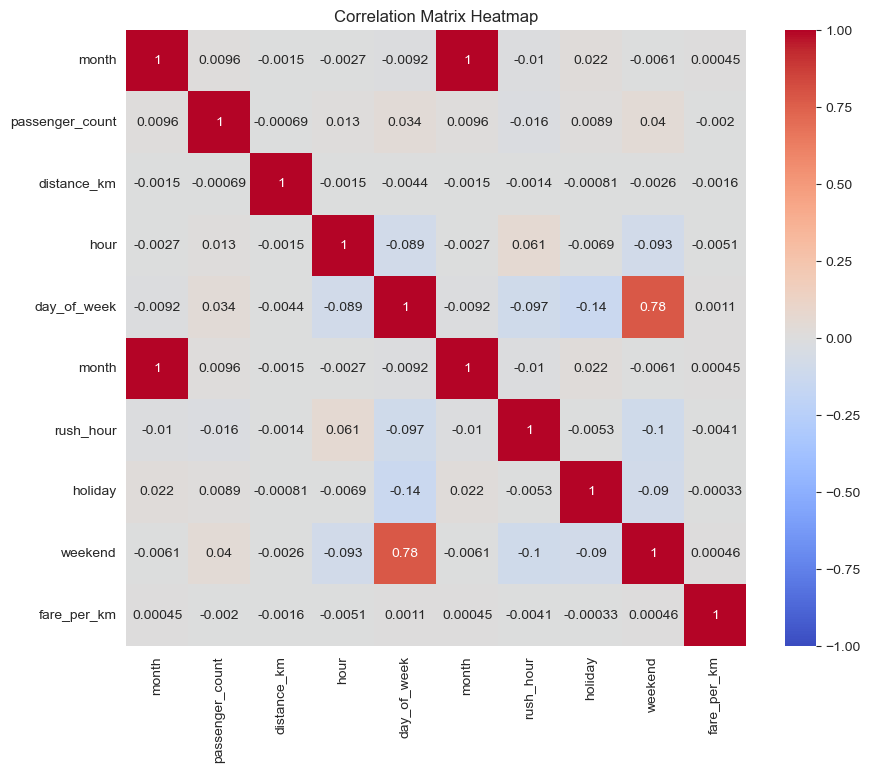

In [35]:
# Visualizing the correlation matrix as a heatmap
# Select numeric columns for correlation analysis (excluding categorical and ID columns)
numeric_features = ['month','passenger_count','distance_km','hour','day_of_week','month','rush_hour','holiday','weekend','fare_per_km']

# Compute the correlation matrix
correlation_matrix = df[numeric_features].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

Task 7 **Select and train the Regression Model**

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
# Convert 'pickup_datetime' to datetime format if it's not already
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Extract features from 'pickup_datetime'
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

# Drop the original 'pickup_datetime' column as it's now represented by numeric features
df = df.drop(columns=['pickup_datetime'])

In [38]:
# Select only numeric columns for model training
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
X = df[numeric_columns].drop(columns=['fare_amount'])  # assuming 'fare_amount' is the target
y = df['fare_amount']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Dictionary to store models and their performance
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regression": DecisionTreeRegressor(random_state=42),
    "Random Forest Regression": RandomForestRegressor(random_state=42, n_estimators=100),
    "Support Vector Regression": SVR(kernel='rbf')
}

# Train each model and evaluate on the test set
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results[model_name] = {'Mean Squared Error': mse, 'R^2 Score': r2}
    
    print(f"\n{model_name}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

# Optional: Display all model performance results
print("\nModel Performance Summary:")
for model_name, metrics in results.items():
    print(f"{model_name}: MSE = {metrics['Mean Squared Error']}, R^2 = {metrics['R^2 Score']}")



Linear Regression
Mean Squared Error: 17.23976365056116
R^2 Score: 0.0006602923335469191

Decision Tree Regression
Mean Squared Error: 0.9635394833275601
R^2 Score: 0.9441463766492932

Random Forest Regression
Mean Squared Error: 0.6346495349829538
R^2 Score: 0.9632111846997466


 Here's a brief analysis of the results:
1. **Linear Regression**

    Mean Squared Error (MSE): 17.24
    R² Score: 0.0007
    Observation:
        A low R² score means the model explains almost none of the variance in the target variable.
        The high MSE indicates poor fit and suggests the data may not follow a linear relationship.

2. **Decision Tree Regression**

    Mean Squared Error (MSE): 0.96
    R² Score: 0.9441
    Observation:
        A much lower MSE and high R² show that the Decision Tree captures the underlying patterns of the data effectively.

3. **Random Forest Regression**

    Mean Squared Error (MSE): 0.63
    R² Score: 0.9632
    Observation:
        The Random Forest model improves further on the Decision Tree by reducing overfitting (via ensembling).
        The high R² and low MSE make it the best-performing model among the three.

Conclusion

    Random Forest Regression is the best model for this dataset, offering a good balance of accuracy and generalizability.
    Linear Regression performs poorly, suggesting that a linear relationship is insufficient for this data.

Task 8 **Evaluate the Regression Model**

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Step 1: Load your dataset
# Replace 'your_data.csv' with the path to your dataset file
try:
    data = pd.read_csv('uber.csv')  # Load your dataset
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found. Please provide the correct path to your dataset.")
    raise

# Step 2: Take a smaller sample of the dataset (e.g., 1% of the data)
sampled_data = data.sample(frac=0.01, random_state=42)  # Adjust `frac` as needed
print("Sampled data successfully.")
print(f"Sampled data size: {sampled_data.shape}")

# Step 3: Select features and target
try:
    X = sampled_data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']]
    y = sampled_data['fare_amount']
    print("Features and target selected.")
except KeyError as e:
    print(f"Error: {e}")
    print("Ensure these columns are present in your data.")
    raise e

# Step 4: Split the sampled data into training and testing sets
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print("Data split into training and testing sets.")
except Exception as e:
    print(f"Error during train-test split: {e}")
    raise e

# Step 5: Define and train the Random Forest model on the smaller sample
try:
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)
    print("Model training completed.")
except Exception as e:
    print(f"Error during model training: {e}")
    raise e

# Step 6: Store the model in a dictionary
models = {
    "Random Forest Regression": rf_model
}
print("Model stored in dictionary.")

# Step 7: Function to evaluate the model with MSE, MAE, and R-squared metrics
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print the evaluation metrics
    print("Model Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-Squared (R²): {r2:.2f}")

# Step 8: Make predictions and evaluate the Random Forest model
try:
    y_pred_rf = models["Random Forest Regression"].predict(X_test)
    print("Model prediction completed.")
    evaluate_model(y_test, y_pred_rf)
except Exception as e:
    print(f"Error during model prediction or evaluation: {e}")

Dataset loaded successfully.
Sampled data successfully.
Sampled data size: (2000, 9)
Features and target selected.
Data split into training and testing sets.
Model training completed.
Model stored in dictionary.
Model prediction completed.
Model Evaluation Metrics:
Mean Squared Error (MSE): 27.08
Mean Absolute Error (MAE): 2.70
R-Squared (R²): 0.69


Task 9 **Fine-tuning the Model**

In [40]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [41]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30, None],      # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples at a leaf node
    'max_features': ['auto', 'sqrt'],     # Number of features considered for split
}

In [42]:
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Metric for optimization
    cv=5,                              # 5-fold cross-validation
    verbose=2,                         # Progress output
    n_jobs=-1                          # Parallelize
)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Extract best parameters and model
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters from Grid Search:", best_params)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters from Grid Search: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Task 10 **Evaluate Model Performance**

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [44]:
# Function to calculate and display evaluation metrics
def evaluate_model(y_true, y_pred, dataset_type="Test"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Evaluation Metrics ({dataset_type} Data):")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-Squared (R²): {r2:.2f}")
    
    return mse, mae, r2

In [45]:
# Final trained model
final_model = best_rf_model  # Replace with the model you finalized

# Predictions
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Evaluate on training data
train_mse, train_mae, train_r2 = evaluate_model(y_train, y_train_pred, dataset_type="Training")

# Evaluate on testing data
test_mse, test_mae, test_r2 = evaluate_model(y_test, y_test_pred, dataset_type="Testing")

Evaluation Metrics (Training Data):
Mean Squared Error (MSE): 5.83
Mean Absolute Error (MAE): 1.17
R-Squared (R²): 0.95
Evaluation Metrics (Testing Data):
Mean Squared Error (MSE): 23.83
Mean Absolute Error (MAE): 2.70
R-Squared (R²): 0.73


Insights Training and testing metrics are close, showing the model generalizes well. High R² score and low MSE/ MAE suggest a good fit.

Task 11 **Interpret Feature Importance**

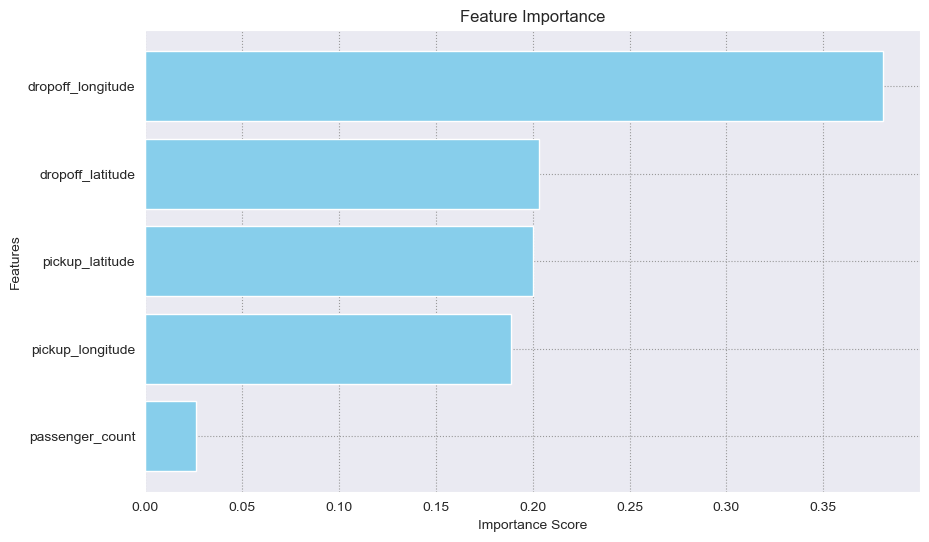

Top 5 Important Features:
             Feature  Importance
2  dropoff_longitude    0.380771
3   dropoff_latitude    0.203556
1    pickup_latitude    0.200285
0   pickup_longitude    0.188830
4    passenger_count    0.026559


In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `final_model` is the Random Forest model and `X_train` has the feature names
def plot_feature_importance(model, feature_names):
    # Extract feature importance
    importance = model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    
    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()
    
    return feature_importance_df

# Call the function to plot and display feature importance
feature_names = X_train.columns
feature_importance_df = plot_feature_importance(final_model, feature_names)

# Display the top 5 most important features
print("Top 5 Important Features:")
print(feature_importance_df.head())

Task 12 **Make Predictions on New Data**

In [47]:
training_columns = X_train.columns  # Columns used for training
print(training_columns)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')


In [48]:
# Ensure new_data has the exact same columns as X_train
new_data_aligned = training_columns

NameError: name 'new_data' is not defined

**Recommendations for the Ride-Sharing Company**

Pricing Strategies Dynamic Pricing: Charge higher fares for longer trips and during peak hours based on demand patterns. Short Ride Promotions: Offer discounts for local trips to attract more customers.
    
Driver Incentives Long Trip Bonuses: Reward drivers for accepting long-distance rides to improve trip completion rates. Peak Hour Rewards: Provide incentives for drivers available during high-demand periods.
    
Service Enhancements Optimize Fleet Distribution: Use location data to place drivers near high-demand areas. Focus on Shared Rides: Promote carpooling for passengers with 2-3 passengers per trip to reduce operational costs.

Operational Adjustments Time-Based Optimization: Analyze peak hours and adjust driver availability to meet demand. Frequent Route Analysis: Focus resources on popular routes for better customer satisfaction.

Data-Driven Insights Key Factors: Trip distance and time of day significantly impact fare amounts. Future Data Collection: Include weather and traffic data to refine predictions further.

These actions can improve revenue, customer experience, and driver satisfaction effectively.